# 决策树

In [ ]:
from sklearn.datasets import load_iris
# 加载数据集
iris = load_iris()

In [ ]:
iris.keys()

In [ ]:
# 加载树模型
from sklearn.tree import DecisionTreeClassifier

In [ ]:
treeClf = DecisionTreeClassifier(max_depth=5)

In [ ]:
x,y = iris.data[:,:2],iris.target

In [ ]:
treeClf.fit(x,y)

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(
    treeClf,
    out_file="./result/iris_tree.dot",
    feature_names=iris["feature_names"][:2],
    class_names=iris["target_names"],
    rounded=True,
    filled=True
)

In [ ]:
# 转换图像
! dot -Tpng ./result/iris_tree.dot -o ./result/iris_tree.png

In [ ]:
from IPython.display import Image
Image(filename="./result/iris_tree.png",width=800,height=800)

In [ ]:
## 回归模型
from sklearn.tree import DecisionTreeRegressor
treeReg = DecisionTreeClassifier(max_depth=5)

In [ ]:
import numpy as np

# 软投票和硬投票

## 概念
- 软投票看的是概率，支持某个概率特别高的分类器的决策行为
- 硬投票看的是结果，采取少数服从多数
  

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# 创建数据集
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

x,y = make_moons(n_samples=500,noise=0.3,random_state=52)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)

In [ ]:
x.shape,y.shape

In [ ]:
plt.plot(x[:,0][y==0],x[:,1][y==0],"yo",alpha=0.6)
plt.plot(x[:,0][y==1],x[:,1][y==1],"bs",alpha=0.6)

## 硬投票实验

In [ ]:
# 导入集成学习的包
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

logClf = LogisticRegression(random_state=42)
randClf = RandomForestClassifier(random_state=42)
svmClf = SVC(random_state=42)
votingClf = VotingClassifier(estimators=[("lr",logClf),("rf",randClf),("svm",svmClf)],voting="hard")

In [ ]:
y_train.shape

In [ ]:
votingClf.fit(x_train,y_train)

In [ ]:
from sklearn.metrics import accuracy_score

for es in (logClf,randClf,svmClf,votingClf):
    es.fit(x_train,y_train)
    y_pre = es.predict(x_test)
    ac = accuracy_score(y_true=y_test,y_pred=y_pre)
    print(es.__class__.__name__,":",ac)

## 软投票实验

In [ ]:
# 导入集成学习的包
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

logClf = LogisticRegression(random_state=42)
randClf = RandomForestClassifier(random_state=42)
svmClf = SVC(random_state=42)
votingClf = VotingClassifier(estimators=[("lr",logClf),("rf",randClf),("svm",svmClf)],voting="hard")

In [ ]:
from sklearn.metrics import accuracy_score

for es in (logClf,randClf,svmClf,votingClf):
    es.fit(x_train,y_train)
    y_pre = es.predict(x_test)
    ac = accuracy_score(y_true=y_test,y_pred=y_pre)
    print(es.__class__.__name__,":",ac)

# bagging

## 训练策略
- 首先对训练数据进行多次采样，保证每次得到的采样数据都是不同的
- 分别训练多个模型，例如：树模型
- 预测试需要得到所有模型的结果在进行集成
- bag在预测的时候使用的软投票机制，也就是用概率值的大小去选择投标结果

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagCls = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    max_samples=100,
    random_state=42,
    n_jobs=-1
)
bagCls.fit(x_train,y_train)

In [ ]:
accuracy_score(y_test,bagCls.predict(x_test))

In [ ]:
treeClf = DecisionTreeClassifier(random_state=42)
treeClf.fit(x_train,y_train)
accuracy_score(y_test,treeClf.predict(x_test))

In [ ]:
# 绘制决策边界--目前只能用到二维
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf,x,y,axes=[-1.5,2.5,-1,1.5],alpha = 0.8, contour = True):
    # 将坐标轴进行切分
    x1s = np.linspace(axes[0],axes[1],100)
    x2s = np.linspace(axes[2],axes[3],100)
    # 按照切分的结果，在坐标轴画线，会形成单元格，下面分别获取单元格的左下角坐标
    # [[1,2],[3,4]] -> x1 = [[1,2],[1,2]],x2 = [[3,3],[4,4]]
    x1,x2 = np.meshgrid(x1s,x2s)
    # 下面再将划分的坐标分别拉平，组成一系列的点，做为样本点
    # 一共的样本点是 100*100个
    x_new = np.c_[x1.ravel(),x2.ravel()]
    # 对样本点进行分类
    y_pred = clf.predict(x_new).reshape(x1.shape)
    # 根据预测结果，涂颜色
    # 根据等值信息填充，若一个区域的值相等，则填充同一种颜色
    cusCMap = ListedColormap(["#1f77b4","#ff7f0e","#2ca02c"]) # 色谱
    plt.contourf(x1,x2,y_pred,cmap = cusCMap,alpha = 0.3)
    if contour: # 是否绘制等值线
        # 下面绘制等值线，类似于山峰的等高线
        CS = plt.contour(x1,x2,y_pred,cmap = cusCMap,alpha=alpha) 
        plt.clabel(CS, inline=1, fontsize=10)
    # 再放上真是的结果
    plt.plot(x[:,0][y==0],x[:,1][y==0],"yo",alpha=0.8)
    plt.plot(x[:,0][y==1],x[:,1][y==1],"bs",alpha=0.8)
    # 坐标范围
    plt.axis(axes)
    plt.xlabel("x1")
    plt.xlabel("x2")

In [ ]:
plt.figure(figsize=(12,5))
# 左边的子图
plt.subplot(121)
#决策树
plot_decision_boundary(treeClf,x,y,alpha=0.3)
plt.title("decision Tree")
# 右边的子图
plt.subplot(122)
#决策树
plot_decision_boundary(bagCls,x,y,alpha=0.3)
plt.title("decision Tree with bagging")

## OOB策略->out of bag

1.  一种将随机策略下未选中的样本，作为验证集的策略

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagClf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    max_samples=100,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)
bagClf.fit(x_train,y_train)
bagClf.oob_score_ # 查看验证集的结果

In [ ]:
y_pred = bagCls.predict(x_test)
accuracy_score(y_test,y_pred)

## 随机森林

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

iris = load_iris()

### 特征重要性

In [ ]:
rfClf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1
)
rfClf.fit(iris["data"],iris["target"])

for name,score in zip(iris["feature_names"],rfClf.feature_importances_):
    print(name+":\t",score)

In [ ]:
from sklearn.datasets import fetch_openml

minist = fetch_openml("mnist_784",parser="auto")
rfClf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1
)
rfClf.fit(minist["data"],minist["target"])

In [ ]:
rfClf.feature_importances_.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
def plot_digit(data:np.ndarray):
    image = data.reshape(28,28)
    plt.imshow(image,cmap=matplotlib.cm.hot)
    plt.axis("off")

In [ ]:
import matplotlib.ticker as ticker
plot_digit(rfClf.feature_importances_)
char  = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=2)  # colorbar上的刻度值个数
char.locator = tick_locator
char.set_ticks([rfClf.feature_importances_.min(), rfClf.feature_importances_.max()]) # 设置刻度值
char.update_ticks()
char.ax.set_yticklabels(['not important','very important'])

# boosting

- 基本思想：加权一些列分类器；（比如，通过准确率作为权重）

In [ ]:
from sklearn.svm import SVC

m = len(x_train)

plt.figure(figsize=(12,4))

for subplot,learning_rate in ((121,1),(122,0.5)):
    sample_weights = np.ones(m)

    plt.subplot(subplot)
    # 构造五个分类器，逐步增加分错的数据的权重
    for i in range(5):
        svmClf = SVC(kernel="rbf",C=0.05,random_state=42)
        svmClf.fit(x_train,y_train,sample_weight=sample_weights)
        y_pred = svmClf.predict(x_train)
        sample_weights[y_pred != y_train] *= (1+learning_rate)
        plot_decision_boundary(svmClf,x,y,alpha=0.3)
    plt.title("learning_rate:"+str(learning_rate))


## adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adaBoostClf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3),
    n_estimators = 200,
    learning_rate=0.5,
    random_state=42
)

In [ ]:
adaBoostClf.fit(x_train,y_train)
plot_decision_boundary(adaBoostClf,x,y)

## GBT

 GBT主要是针对上一轮预测的残差做优化

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [ ]:
np.random.seed(42)
x = np.random.rand(100,1) - 0.5
y = 3*x[:,0]**2 + 0.05*np.random.randn(100)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
treeReg1 = DecisionTreeRegressor()
treeReg1.fit(x,y)

In [ ]:
# 第二次
y2 = y - treeReg1.predict(x)
treeReg2 = DecisionTreeRegressor()
treeReg2.fit(x,y2)

In [ ]:
# 第二次
y3 = y2-  treeReg2.predict(x)
treeReg3 = DecisionTreeRegressor()
treeReg3.fit(x,y3)

In [ ]:
x_new = np.array([[0.8]])
y_pred = sum(tree.predict(x_new) for tree in (treeReg1,treeReg2,treeReg3))

In [ ]:
x_new

In [ ]:
y_pred,3*x_new[:,0]**2 

In [ ]:
# sklearn gbt
from sklearn.ensemble import GradientBoostingRegressor
gbt = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0, # 是每棵树的占比，不是梯度下降的学习率
    random_state=42
)
gbt.fit(x,y)

In [ ]:
# sklearn gbt
from sklearn.ensemble import GradientBoostingRegressor
gbt_slow_2 = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=0.1, # 是每棵树的占比，不是梯度下降的学习率
    random_state=42
)
gbt_slow_2.fit(x,y)

In [ ]:
# sklearn gbt
from sklearn.ensemble import GradientBoostingRegressor
gbt_slow_3 = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=200,
    learning_rate=0.1, # 是每棵树的占比，不是梯度下降的学习率
    random_state=42
)
gbt_slow_3.fit(x,y)

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_predictions([gbt],x,y,axes=[-0.5,0.5,-0.1,0.8],label="Ensembel predictions")
plt.title("learning rate:{},n_estimators:{}".format(gbt.learning_rate,gbt.n_estimators_))

plt.subplot(122)
plot_predictions([gbt_slow_2],x,y,axes=[-0.5,0.5,-0.1,0.8],label="Ensembel predictions")
plt.title("learning rate:{},n_estimators:{}".format(gbt_slow_2.learning_rate,gbt_slow_2.n_estimators_))

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_predictions([gbt_slow_2],x,y,axes=[-0.5,0.5,-0.1,0.8],label="Ensembel predictions")
plt.title("learning rate:{},n_estimators:{}".format(gbt_slow_2.learning_rate,gbt_slow_2.n_estimators_))

plt.subplot(122)
plot_predictions([gbt_slow_3],x,y,axes=[-0.5,0.5,-0.1,0.8],label="Ensembel predictions")
plt.title("learning rate:{},n_estimators:{}".format(gbt_slow_3.learning_rate,gbt_slow_3.n_estimators_))

## 提前停止策略

In [101]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=49)
# sklearn gbt
gbrt = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=120,
    random_state=42
)
gbrt.fit(x_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

In [102]:
from sklearn.metrics import mean_squared_error
errors = [mean_squared_error(y_test,y_pred) for y_pred in gbrt.staged_predict(x_test)]
best_n_est = np.argmin(errors)
print(best_n_est,errors[116])

55 0.002942592127188862


In [103]:
# sklearn gbt
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=117,
    random_state=42
)
gbrt_best.fit(x_train,y_train)
mean_squared_error(y_test,gbrt_best.predict(x_test))

0.002942592127188862

In [104]:
min_error = np.min(errors)
min_error

0.002712853325235463

Text(0.5, 1.0, 'Best models55')

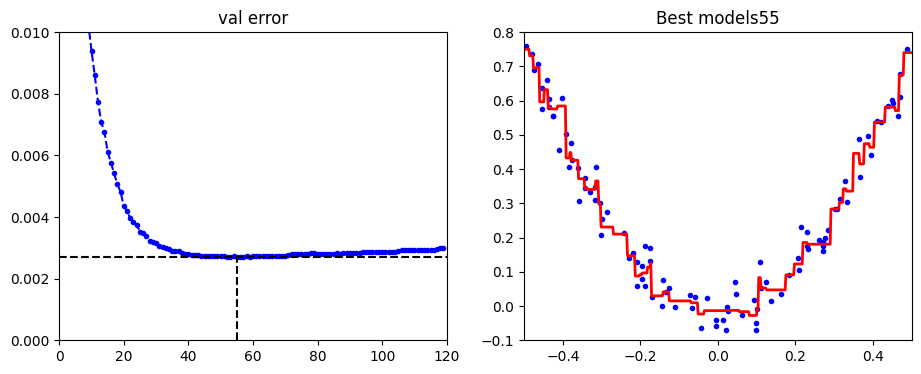

In [110]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(errors,"b.--")
plt.plot([best_n_est,best_n_est],[0,min_error],"k--")
plt.plot([0,120],[min_error,min_error],"k--")
plt.axis([0,120,0,0.01])
plt.title("val error")

plt.subplot(122)
plot_predictions([gbrt_best],x,y,axes=[-0.5,0.5,-0.1,0.8])
plt.title("Best models"+str(best_n_est))
# plt.subplot(122)
# plot_predictions([gbt_slow_3],x,y,axes=[-0.5,0.5,-0.1,0.8],label="Ensembel predictions")
# plt.title("learning rate:{},n_estimators:{}".format(gbt_slow_3.learning_rate,gbt_slow_3.n_estimators_))

In [112]:
gbrt = GradientBoostingRegressor(max_depth = 2,
                             random_state = 42,
                                 warm_start =True
)
error_going_up = 0
min_val_error = float('inf')

for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(x_train,y_train)
    y_pred = gbrt.predict(x_test)
    val_error = mean_squared_error(y_test,y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up +=1
        if error_going_up == 5:
            break
        

In [113]:
print (gbrt.n_estimators)

61
